-----

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
CURRENT_DIR = Path('.').resolve()
MODULES_DIR = CURRENT_DIR.parent.joinpath('src')
sys.path.append(str(MODULES_DIR))
DATA_DIR = CURRENT_DIR.parent.joinpath('Data','Process')

In [7]:
df = pd.read_csv(str(DATA_DIR)+'/taxi.csv',index_col=0)

-----

# Feature engineering

We shall create features based on the date and time of pickup, and location-related features.

## Temporal features
Ridership volume depends heavily on theday of the week, as well as the time day

In [11]:
df.loc[:5,['pickup_datetime', 'year', 'month','day', 'day_of_week', 'hour']]

,pickup_datetime,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21+00:00,2009,6,15,0,17
1,2010-01-05 16:52:16+00:00,2010,1,5,1,16
2,2011-08-18 00:35:00+00:00,2011,8,18,3,0
3,2012-04-21 04:30:42+00:00,2012,4,21,5,4
4,2010-03-09 07:51:00+00:00,2010,3,9,1,7
5,2011-01-06 09:50:45+00:00,2011,1,6,3,9


In [12]:
df = df.drop(['pickup_datetime'], axis=1)

In [13]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7


## Geolocation features

There is no information regarding the distance between the pickup and drop off points, which is arguably the most important factor in deciding taxi fares

In [14]:
import c3.math_func as mf

In [23]:
df['distance'] = mf.euc_distance(df.pickup_latitude.values,
                              df.pickup_longitude.values,
                              df.dropoff_latitude.values,
                              df.dropoff_longitude.values)

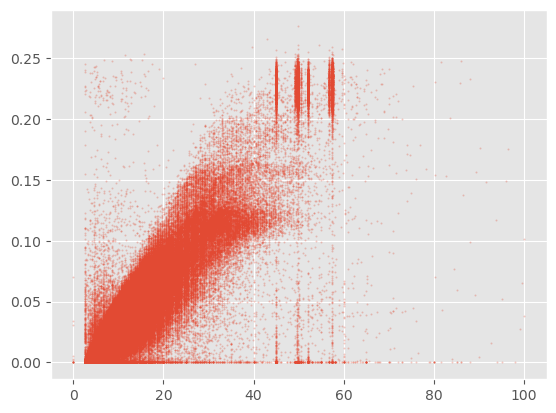

In [36]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.scatter(x = df.fare_amount,
           y = df.distance,
           s = 1,
           alpha=0.2)
plt.show()

If we look at the center of the graph, we can see three vertical
lines of dots. These outlier data seems to suggest that there are certain trips where the distance traveled did not have an impact on the fare amount (which is between $40 and $60 for these outliers). Recall in the previous section on data visualization where we saw that
there are certain pickups near airports, and these airport pickups have a flat fare of $52 plus tolls. This could explain the three vertical lines of dots between $40 and $60!

We can use our function to calculate the pickup and drop off distance from the three major airports in NYC

In [37]:
airports = {'JFK_Airport': (-73.78,40.643),
            'Laguardia_Airport': (-73.87, 40.77),
            'Newark_Airport' : (-74.18, 40.69)}

for airport in airports:
    df['pickup_dist_'+ airport] = mf.euc_distance(df.pickup_latitude.values,
                                                  df.pickup_longitude.values,
                                                  airports[airport][1],
                                                  airports[airport][0])
    
for airport in airports:
    df['dropoff_dist_'+ airport] = mf.euc_distance(df.dropoff_latitude.values,
                                                  df.dropoff_longitude.values,
                                                  airports[airport][1],
                                                  airports[airport][0])

In [38]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,pickup_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_JFK_Airport,dropoff_dist_Laguardia_Airport,dropoff_dist_Newark_Airport
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0.009436,0.101340,0.055043,0.337147,0.092710,0.064326,0.339123
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,0.079696,0.245731,0.157402,0.165330,0.242961,0.109925,0.220812
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,0.013674,0.234714,0.113076,0.209742,0.237050,0.122790,0.198236
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0.025340,0.225895,0.122792,0.197636,0.240846,0.122149,0.200358
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,0.019470,0.225847,0.098115,0.225807,0.225878,0.087741,0.242228


-----

## Feature scaling

As a final preprocessing step, we should also scale our features before passing them to the neural network

Before we scale the features in the DataFreme, it's a good idea to keep a copy of the prescaled DataFrame. The valuos of the features will be transformed after scaling, which can make it difficult for us to interpret the values.

In [42]:
df_prescaled = df.copy()

We should also drop the `fare_amount` target varaible before scaling, as we do not wanto to modify the taget varible

In [43]:
df_scaled = df.drop(['fare_amount'],axis=1)

In [45]:
from sklearn.preprocessing import scale

df_scaled = scale(df_scaled)

In [59]:
cols = df.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
df_scaled = pd.concat([df_scaled, df['fare_amount']], axis=1)
df = df_scaled.copy()

In [60]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,pickup_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_JFK_Airport,dropoff_dist_Laguardia_Airport,dropoff_dist_Newark_Airport,fare_amount
0,3.916896,-1.128227,4.151116,-1.365537,-0.526888,-1.469611,-0.078187,-0.078219,-1.560801,0.535442,-0.646405,-3.957854,-2.321151,3.494461,-4.628070,-1.901119,3.621417,4.5
1,-1.203464,-1.510227,-0.146055,1.083475,-0.526888,-0.932852,-1.531625,-1.230176,-1.047515,0.381408,1.292368,0.651855,1.791541,-1.403329,0.631996,-0.076296,0.144374,16.9
2,-0.210322,0.395464,-0.519838,-0.020874,0.239932,-0.396092,0.503188,0.267369,-0.020945,-2.083145,-0.529455,0.300110,0.010540,-0.137330,0.425078,0.438538,-0.519138,5.7
3,-0.341270,-0.677271,-0.529984,0.243605,-0.526888,0.140667,-0.659562,0.612956,1.005625,-1.467007,-0.207528,0.018578,0.400941,-0.482410,0.557964,0.412867,-0.456748,7.7
4,0.226261,0.652445,0.559839,1.145221,-0.526888,-0.932852,-0.950250,-0.769393,-1.047515,-1.004903,-0.369533,0.017033,-0.590553,0.320629,0.033960,-0.964083,0.773758,5.3


In [61]:
df.to_csv(str(DATA_DIR)+'/taxi_sc.csv')

In [62]:
df_prescaled.to_csv(str(DATA_DIR)+'/taxi_sc_prescaling.csv')